In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [3]:
def prepare_image(file):
    img_path = 'data/image_samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

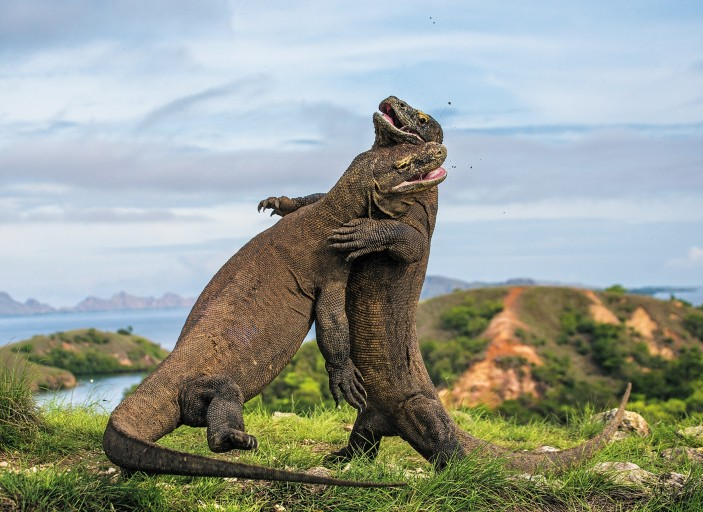

In [4]:
from IPython.display import Image
Image(filename='data/image_samples/3.jpeg', width=300,height=200) 

In [5]:
preprocessed_image = prepare_image('3.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01688243', 'frilled_lizard', 0.53259),
  ('n01695060', 'Komodo_dragon', 0.17175229),
  ('n01677366', 'common_iguana', 0.16455686),
  ('n01687978', 'agama', 0.032569163),
  ('n02127052', 'lynx', 0.024667187)]]

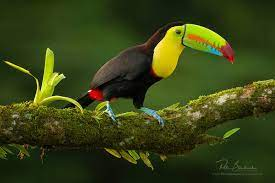

In [6]:
Image(filename='data/image_samples/5.jpeg', width=300,height=200) 

In [7]:
preprocessed_image = prepare_image('5.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01843383', 'toucan', 0.9990175),
  ('n02017213', 'European_gallinule', 0.00031545197),
  ('n01608432', 'kite', 0.00017865699),
  ('n02606052', 'rock_beauty', 0.00012763792),
  ('n01614925', 'bald_eagle', 7.09272e-05)]]

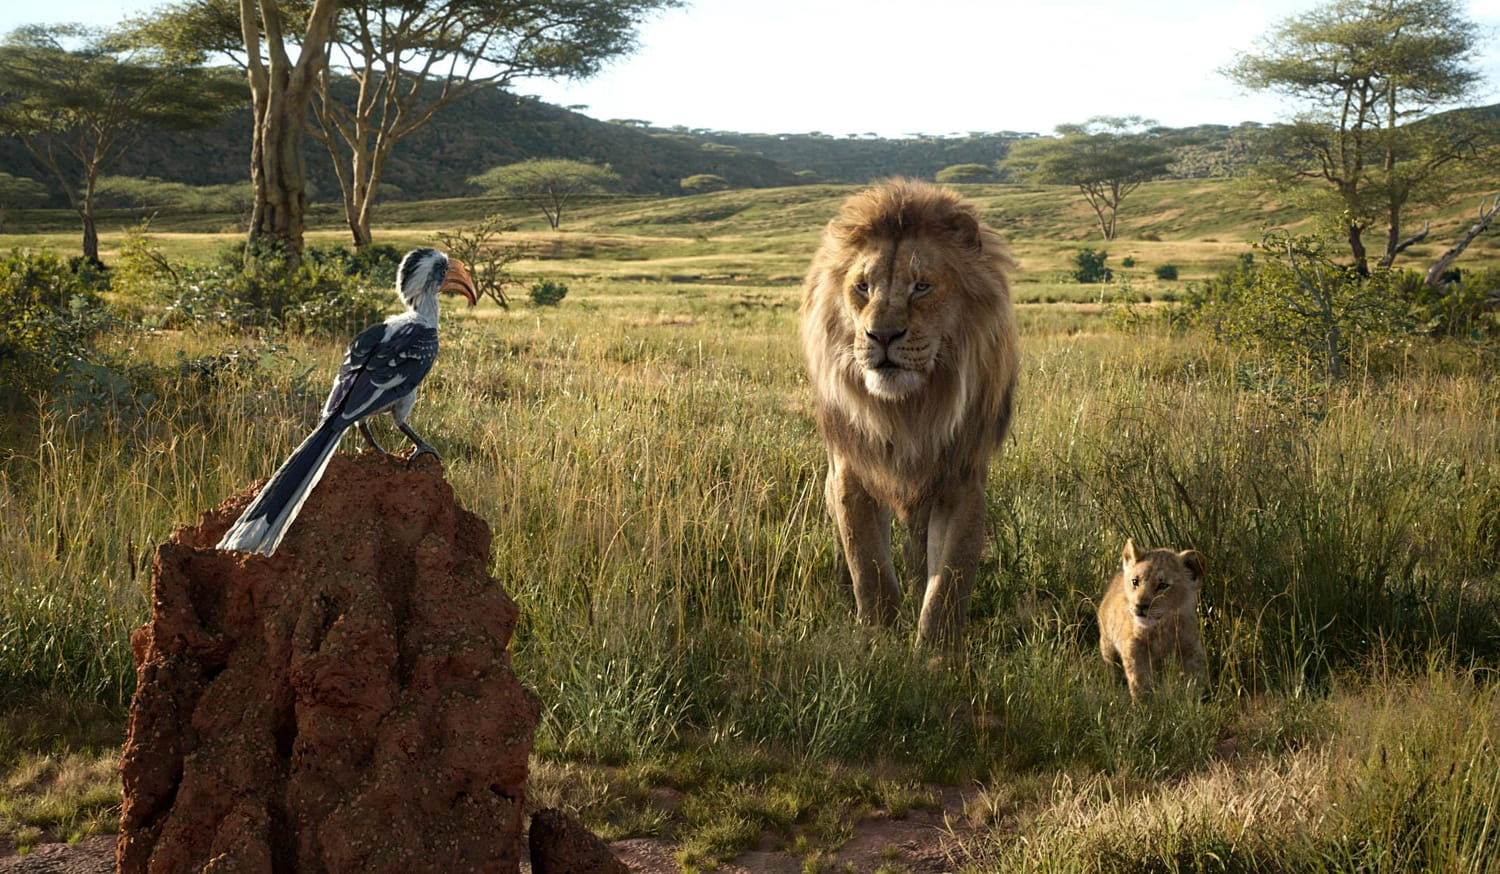

In [8]:
Image(filename='data/image_samples/1.jpeg', width=300,height=200) 

In [9]:
preprocessed_image = prepare_image('1.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02092002', 'Scottish_deerhound', 0.33165714),
  ('n02106030', 'collie', 0.11618956),
  ('n02090622', 'borzoi', 0.07959263),
  ('n02129165', 'lion', 0.07217754),
  ('n02117135', 'hyena', 0.03521989)]]

In [ ]:
# Organize data into train, valid, test dirs
os.chdir('Sign-Language-Digits-Dataset/')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [10]:
train_path = 'Sign-Language-Digits-Dataset/train/'
valid_path = 'Sign-Language-Digits-Dataset/valid/'
test_path = 'Sign-Language-Digits-Dataset/test/'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Modify model

In [11]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [12]:
type(mobile)

keras.engine.functional.Functional

In [13]:
# Take upuntil the last 6 layers
x = mobile.layers[-6].output
#set the new output layer
output = Dense(units=10, activation='softmax')(x)

In [14]:
model = Model(inputs=mobile.input, outputs=output)

In [15]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Train the model

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
172/172 - 42s - loss: 0.6034 - accuracy: 0.8213 - val_loss: 0.3812 - val_accuracy: 0.8667
Epoch 2/30
172/172 - 41s - loss: 0.1151 - accuracy: 0.9825 - val_loss: 0.0877 - val_accuracy: 0.9700
Epoch 3/30
172/172 - 41s - loss: 0.0607 - accuracy: 0.9889 - val_loss: 0.0476 - val_accuracy: 0.9933
Epoch 4/30
172/172 - 42s - loss: 0.0312 - accuracy: 0.9959 - val_loss: 0.0450 - val_accuracy: 0.9867
Epoch 5/30
172/172 - 42s - loss: 0.0277 - accuracy: 0.9971 - val_loss: 0.0322 - val_accuracy: 0.9900
Epoch 6/30
172/172 - 45s - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9967
Epoch 7/30
172/172 - 44s - loss: 0.0112 - accuracy: 0.9994 - val_loss: 0.0233 - val_accuracy: 0.9900
Epoch 8/30
172/172 - 41s - loss: 0.0110 - accuracy: 0.9988 - val_loss: 0.0570 - val_accuracy: 0.9767
Epoch 9/30
172/172 - 41s - loss: 0.0170 - accuracy: 0.9965 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 10/30
172/172 - 41s - loss: 0.0076 - accuracy: 0.9994 - val_loss: 0.0168 - val_accura

# Predictions on the model

In [20]:
test_labels = test_batches.classes

In [21]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [22]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


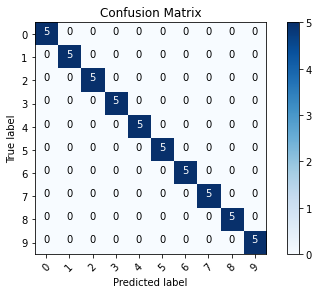

In [24]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')